# モジュール

In [17]:
import os
import sys
import warnings

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
sys.path.append(os.getcwd())
sys.path.append("..")
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
# TF/Keras
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.layers import Input, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.manifold import TSNE



In [18]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# フォントの設定
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = [
    "Hiragino Gothic Pro",
    "Yu Gothic",
    "Meirio",
    "Takao",
    "IPAexGothic",
    "IPAPGothic",
    "VL PGothic",
    "Noto Sans CJK JP",
]
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 17
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
# 軸の設定
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["axes.linewidth"] = 2.0
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["grid.color"] = "black"

# 凡例の設定
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["legend.handlelength"] = 1.0
plt.rcParams["legend.labelspacing"] = 0.4
plt.rcParams["legend.handletextpad"] = 0.8
plt.rcParams["legend.markerscale"] = 1.0

# Data



In [19]:

def make_timeseries_dataset(data, target, timesteps):
    #タイムステップ分ずらす
    N = len(target[timesteps:])
    X = np.zeros((N, timesteps, 1), np.float32)
    Y = np.zeros((N, 1), np.float32)
    for i in range(N):
        X[i] = data[i:i+timesteps][:,np.newaxis]
        Y[i] = target[i+timesteps]
    return X, Y

def make_dataset_for_stateful(data_list, target_list, timesteps):
    N = len(data_list)
    X = []
    Y = []
    for i in range(N):
        x, y = make_timeseries_dataset(data_list[i], target_list[i], timesteps)
        X.append(x)
        Y.append(y)
    X = np.concatenate(X, axis=(1)).reshape(-1, timesteps, 1)
    Y = np.concatenate(Y, axis=(1)).reshape(-1, 1)

    return X, Y

# Model

In [20]:
def build_encoder(input_shape, h_dim, z_dim, name="encoder"):
    #入力層
    inputs = keras.layers.Input(shape=input_shape)
    #隠れ層，h_dim個のユニット，ReLU関数
    #入力データを非線形変換
    x = keras.layers.Dense(h_dim, activation="relu")(inputs)
    #別の隠れ層，ネットワークの表現能力を向上
    x = keras.layers.Dense(h_dim, activation="relu")(x)
    z_mean = keras.layers.Dense(z_dim, name="z_mean")(x)
    z_log_var = keras.layers.Dense(z_dim, name="z_log_var")(x)
    #潜在空間の平均と対数分散を出力
    outputs = [z_mean, z_log_var]
    
    
    return keras.Model(inputs=inputs, outputs=outputs, name=name)

#事前モデル分布
def build_prior(input_shape, h_dim, z_dim, name="prior"):
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.Dense(h_dim, activation="relu")(inputs) 
    prior_mean = keras.layers.Dense(z_dim, name="prior_mean")(x)
    prior_log_var = keras.layers.Dense(z_dim, name="prior_log_var")(x)
    #潜在空間の事前分布の平均を出力
    outputs = [prior_mean, prior_log_var]
    
    return keras.Model(inputs=inputs, outputs=outputs, name=name)

def build_decoder(input_shape, h_dim, x_dim, name="decoder"):
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.Dense(h_dim, activation="relu")(inputs)
    x = keras.layers.Dense(h_dim, activation="relu")(x)
    x = keras.layers.Dense(x_dim)(x)
    outputs = x
    
    return keras.Model(inputs=inputs, outputs=outputs, name=name)

class Sampling(keras.layers.Layer):
    def __init__(self, name="sampling"):
        super().__init__(name=name)
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        #潜在変数 = 期待値(u) + 標準偏差(σ) * 乱数
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [21]:
class VRNNCell(keras.layers.Layer):
    def __init__(self, h_dim, z_dim):
        super().__init__()
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.state_size = h_dim

    def build(self, input_shape):
        batch_size, x_dim = input_shape

        #phi 特徴抽出
        self.phi_x_layer = keras.Sequential([
            keras.layers.Input((x_dim)),
            keras.layers.Dense(self.h_dim, activation="relu"),
            keras.layers.Dense(self.h_dim, activation="relu")
        ])
        self.phi_z_layer = keras.layers.Dense(self.h_dim, activation="relu")
        self.encoder = build_encoder(input_shape=(self.h_dim+self.h_dim), h_dim=self.h_dim, z_dim=self.z_dim)
        self.prior_layer = build_prior(input_shape=(self.h_dim), h_dim=self.h_dim, z_dim=self.z_dim)
        self.decoder = build_decoder(input_shape=(self.h_dim+self.h_dim), h_dim=self.h_dim, x_dim=x_dim)

        self.rnn_cell = keras.layers.GRUCell(self.h_dim)

        self.sampling_layer = Sampling()

    def call(self, inputs, states):
        h = states[0]   # B x h_dim

        phi_x = self.phi_x_layer(inputs)    # B x h_dim
        x = keras.layers.Concatenate(axis=(1))([phi_x, h])  # B x h_dim+h_dim

        # encoder
        z_mean, z_log_var = self.encoder(x)     # B x z_dim, B x z_dim

        # prior
        prior_mean, prior_log_var = self.prior_layer(h)     # B x z_dim, B x z_dim

        # reparametrization trick
        z = self.sampling_layer([z_mean, z_log_var])    # B x z_dim

        phi_z = self.phi_z_layer(z)     # B x z_dim
        x = keras.layers.Concatenate(axis=(1))([phi_z, h])  # B x h_dim+h_dim

        #decoder
        y = self.decoder(x)   # B x z_dim

        #recurrence
        phi = keras.layers.Concatenate(axis=(1))([phi_x, phi_z])
        _, new_h = self.rnn_cell(phi, [h])    # B x h_dim

        outputs = [y, z_mean, z_log_var, prior_mean, prior_log_var, z, phi_z, h]
        new_states = [new_h]    # 1 x B x h_dim
        return outputs, new_states

In [22]:
class VRNN(keras.Model):
    def __init__(self, input_shape, h_dim=100, z_dim=32, return_sequences=False, name="vrnn", *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)
        self.cell = VRNNCell(h_dim=h_dim, z_dim=z_dim)
        self.axis = (1, 2) if return_sequences else (1)

        # build model
        inputs = keras.layers.Input(input_shape)
        x = keras.layers.RNN(self.cell, return_sequences=return_sequences)(inputs)
        outputs = x
        self.rnn = keras.Model(inputs=inputs, outputs=outputs)

    def call(self, inputs, training=False):
        return self.rnn(inputs)
    
    def compile(self, optimizer, loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.optimizer = optimizer
        self.loss = loss

        # Tracker
        self.total_cost_tracker = keras.metrics.Mean(name="total_cost")
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.kl_tracker = keras.metrics.Mean(name="kl_divergence")

    @property
    def metrics(self):
        return [
            self.total_cost_tracker,
            self.loss_tracker,
            self.kl_tracker
        ]

    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape() as tape:
            outputs = self.rnn(x)
            y_pred, z_mean, z_log_var, prior_mean, prior_log_var, z, phi_z, h = outputs

            # loss
            loss = tf.reduce_mean(self.loss(y_true, y_pred))

            # KL-divergence
            term1 = prior_log_var - z_log_var
            term2 = (tf.exp(z_log_var) + tf.square(z_mean - prior_mean)) / (tf.exp(prior_log_var) + 1e-12)
            term3 = -1
            kl = tf.reduce_mean(tf.reduce_sum(0.5 * (term1 + term2 + term3), axis=self.axis))

            # term1 = (prior_log_var - z_log_var)
            # term2 = (tf.exp(z_log_var) + tf.square(z_mean - prior_mean)) / (2 * tf.exp(prior_log_var) + 1e-12)
            # term3 = -0.5
            # kl = tf.reduce_mean(tf.reduce_sum((term1 + term2 + term3), axis=self.axis))

            total_cost = loss + kl

        grads = tape.gradient(total_cost, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update
        self.total_cost_tracker.update_state(total_cost)
        self.loss_tracker.update_state(loss)
        self.kl_tracker.update_state(kl)
        
        return {m.name: m.result() for m in self.metrics}

#  データの取得

## old

In [13]:
#old
# data_G = np.loadtxt('data/G_DOSE_10-5.csv', delimiter=',')
# data_Q = np.loadtxt('data/Q_DOSE_10-5.csv', delimiter=',')
data_Qex =np.loadtxt('/data/Users/tsutsumi/VRNN/data/old/data_10-8_-7_-6,-6_-7_-8_Q_100_2450.csv', delimiter=',')
# T x N -> N x T
# x = data_Q.transpose((1, 0))
x_2450 = data_Qex
# y = data_G[:700, :].transpose((1, 0))

#1, 5, 9, 11, 15, 16, 18, 20, 22, 25, 26
rows = [0, 4, 8, 10, 14, 15, 17, 19, 21, 24, 25]
x_2450_edit = x_2450[rows, :]


In [14]:
# #データ前処理
# x_init = x - x[:, 0].reshape((8, 1))
# x_init_max = np.max(x_init)
# x_init_min = np.min(x_init)
# x_norm = x_init/(x_init_max - x_init_min)

# y_init = y - y[:, 0].reshape((8, 1))
# y_init_max = np.max(y_init)
# y_init_min = np.min(y_init)
# y_norm = y_init/(y_init_max - y_init_min)

# x_2450_init = x_2450 - x_2450[:, 0].reshape((27, 1))
# x_2450_init_max = np.max(x_init)
# x_2450_init_min = np.min(x_init)
# x_2450_norm = x_2450_init/(x_2450_init_max - x_2450_init_min)


## new

In [24]:
# new
Q_876 = pd.read_csv('/data/Users/tsutsumi/VRNN/data/Original_Data/Figure3/paQuasAr3_dia10-8_-7_-6.csv', encoding='utf-8')
G_876 = pd.read_csv('/data/Users/tsutsumi/VRNN/data/Original_Data/Figure3/GCaMP_dia10-8_-7_-6.csv', encoding='utf-8')

# NumPy 配列に変換
Q_876_numpy = Q_876.to_numpy()
G_876_numpy = G_876.to_numpy()

# 配列の転置（N x Tにする）(27, 1199)
x_Q876 = Q_876.to_numpy().transpose((1, 0))
x_G876 = G_876.to_numpy().transpose((1, 0))

x_Q876x200 = (x_Q876-1) * 2000
x_G876x200 = (x_G876-1) * 2000


In [16]:
# t = np.linspace(0, 1, 1199)
# for i, x_ in enumerate(x_876):
#     plt.plot(t, x_, linestyle="-")
#     plt.title("ID:{}".format(i+1))
#     plt.legend()
#     plt.grid()

#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)

#     plt.xlabel('Frame', fontsize=18)
#     plt.ylabel('Responce', fontsize=18)
#     plt.savefig(f"/data/Users/tsutsumi/VRNN/data/Q/frame1199_No{i+1}_876_.png")
#     plt.show()

# データ確認，設定

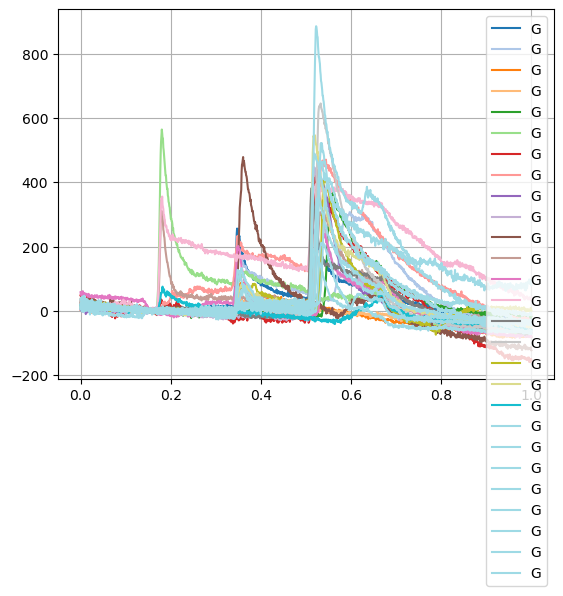

In [8]:
cmap = plt.get_cmap("tab20")

t = np.linspace(0, 1, 1199)
# Check
plt.figure()
for i, x_ in enumerate(x_G876x200):
    plt.plot(t, x_, linestyle="-", color=cmap(i),label = "G")
    #plt.plot(t, y_, linestyle="--", color=cmap(i), label = "Q")
plt.legend()
plt.grid()
plt.show()

## old

In [98]:
timesteps = 10

# #700frame
# x_norm1 = x_norm[:5, :]
# y_norm1 = x_norm[:5, :]

# train_x, train_y = make_dataset_for_stateful(x_norm1, y_norm1, timesteps)

# #2450frame
# x_ex = data_Qex[:20, :]
# y_ex = data_Qex[:20, :]
x_ex = x_2450[:20, :]
y_ex = x_2450[:20, :]
train_x, train_y = make_dataset_for_stateful(x_ex, y_ex, timesteps)

#分割版
# x_ex_split = x_ex[:, :100]
# y_ex_split = y_ex[:, :100]

# #正規化版データ
# x_2450_norm1 = x_2450_norm[:20, :]
# y_2450_norm1 = x_2450_norm[:20, :]

# train_x, train_y = make_dataset_for_stateful(x_2450[:20, :], x_2450[:20, :], timesteps)

## new

In [36]:
timesteps = 50

x_ = x_G876x200[:10, :]
y_ = x_G876x200[:10, :]

train_x, train_y = make_dataset_for_stateful(x_, y_, timesteps)

# モデルの取得

In [43]:
#ハイパラ
x_dim = 1
h_dim = 100
z_dim = 4
learning_rate = 0.0001
epochs=30

model = VRNN(input_shape=(timesteps, x_dim), h_dim=h_dim, z_dim=z_dim)

# 学習


In [44]:
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss=loss)

#%load_ext tensorboard
# TensorBoardコールバックの作成
#tb_cb1 = tf.keras.callbacks.TensorBoard(
#histogram_freq=1,
#write_images=True
#)
#1, 5, 9, 11, 15, 16, 18, 20, 22, 25, 26


In [45]:
hist = model.fit(
    train_x, train_y,
    batch_size=10,
    epochs=epochs,
    #callbacks=[tb_cb1]
)

Epoch 1/30


1149/1149 [==============================] - 154s 127ms/step - total_cost: 30772.4316 - loss: 4320.2891 - kl_divergence: 26452.1113
Epoch 2/30
1149/1149 [==============================] - 147s 128ms/step - total_cost: 389.7409 - loss: 354.4935 - kl_divergence: 35.2471
Epoch 3/30
1149/1149 [==============================] - 147s 128ms/step - total_cost: 69.3554 - loss: 60.2949 - kl_divergence: 9.0604
Epoch 4/30
1149/1149 [==============================] - 144s 125ms/step - total_cost: 46.2860 - loss: 40.8591 - kl_divergence: 5.4268
Epoch 5/30
1149/1149 [==============================] - 147s 128ms/step - total_cost: 41.4366 - loss: 36.7127 - kl_divergence: 4.7239
Epoch 6/30
1149/1149 [==============================] - 144s 126ms/step - total_cost: 38.0366 - loss: 33.6368 - kl_divergence: 4.3998
Epoch 7/30
1149/1149 [==============================] - 144s 126ms/step - total_cost: 35.9641 - loss: 31.8053 - kl_divergence: 4.1588
Epoch 8/30
1149/1149 [==============================] - 146s 

# 推論

In [63]:
id = 27
pre_id = id - 1

# old
# x_2450_ = x_2450[pre_id].reshape(1, -1)

# test_x, _ = make_dataset_for_stateful(x_2450_, x_2450_, timesteps)

x_876_ = x_G876x200[pre_id].reshape(1, -1)


test_x, _ = make_dataset_for_stateful(x_876_, x_876_, timesteps)


outputs = model(test_x)

pred_y = outputs[0]
z = outputs[5]

## 結果

<function matplotlib.pyplot.show(close=None, block=None)>

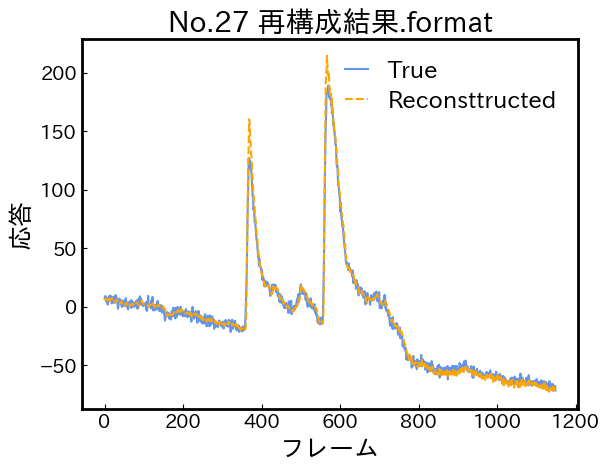

In [64]:
plt.figure()
plt.title(f"No.{id} 再構成結果.format")
plt.plot(np.squeeze(x_G876x200[pre_id, 50:]), linestyle="-", color="cornflowerblue", label = "True")
plt.plot(np.squeeze(pred_y), linestyle="--", color="orange", label = "Reconsttructed")

plt.legend()
plt.grid()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('フレーム', fontsize=18)
plt.ylabel('応答', fontsize=18)

plt.savefig(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/50/train/No_{id}_z{z_dim}h{h_dim}{learning_rate}.png")
plt.show

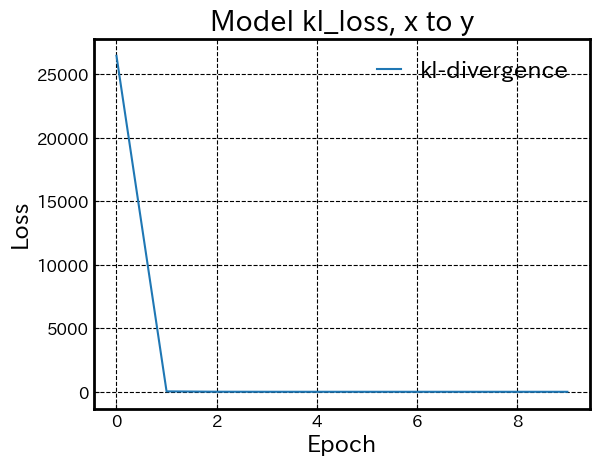

In [ ]:
#学習曲線
#plt.plot(hist.history['loss'][:10], label = "loss")
plt.plot(hist.history['kl_divergence'][:10], label = "kl-divergence")
plt.title('Model kl_loss, x to y')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/50/train/kl_loss.png")
plt.show()


### tsne

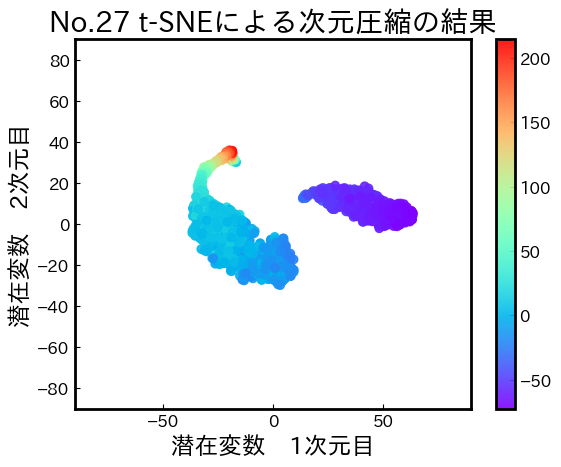

In [67]:
prexity = 35
iter = 1000
learning = 200
pre = "35"
ite = "1000"
learn = "200"
tsne = TSNE(n_components=2, perplexity=prexity, learning_rate=learning, n_iter = iter)

proj = tsne.fit_transform(z)
scatter = plt.scatter(proj[:, 0], proj[:, 1], c=pred_y, cmap="rainbow", alpha=0.9, vmin=min(pred_y), vmax=max(pred_y))

plt.title(f"No.{id} t-SNEによる次元圧縮の結果")
plt.xlabel("潜在変数　1次元目")
plt.ylabel("潜在変数　2次元目")
colorbar = plt.colorbar(scatter)

plt.xlim(-90,90)  # x軸の範囲設定
plt.ylim(-90,90)  # y軸の範囲設定

plt.grid()
plt.savefig(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/50/train/t_SNE_No{id}.png")

In [69]:
np.save(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/50/train/z_No{id}_z{z_dim}h{h_dim}{learning_rate}.npy", z)
np.save(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/50/train/proj_No{id}_z{z_dim}h{h_dim}{learning_rate}.npy", proj)
np.save(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/50/train/pred_No{id}_z{z_dim}h{h_dim}{learning_rate}", pred_y)

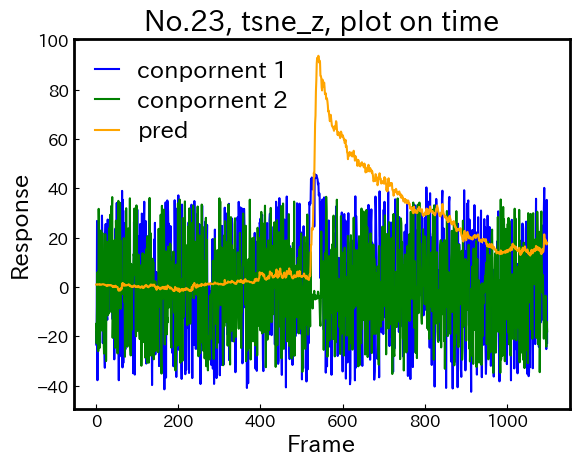

In [ ]:
plt.title(f"No.{id}　t-SNEによる次元圧縮の時系列の変化")
plt.plot(proj[:, 0], label = "一次元目", color = "blue")
plt.plot(proj[:, 1], label = "二次元目", color = "green")
plt.plot(pred_y, label  = "再構成", color = "orange")
plt.xlabel('フレーム')
plt.ylabel('応答')

plt.grid()
plt.legend()
plt.savefig(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/50/train/No{id}_tsne_plot12.png")


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 例: proj, pred_y, zなどの変数が定義されていると仮定
num_frames = 1189  # アニメーションのフレーム数
prints_per_frame = 1189  # 各フレームのデータポイント数
tg = "z"
tt = np.linspace(0, 1, 1189)

# プロットの設定
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# ax1: 散布図の初期設定
scat = ax1.scatter(proj[:, 0], proj[:, 1], c=pred_y, cmap="rainbow", alpha=0.9)
ax1.set_title("No.{:>2d}, tsne_{}, , h_dim ={:<3d}, z_dim = {:>2d}, Epoch = {:>3d}".format(id, tg, h_dim, z_dim, epochs))
ax1.set_ylabel('{}[1]'.format(tg))
ax1.set_xlabel('{}[0]'.format(tg))

ax1.grid()
colorbar = plt.colorbar(scat)
time_text1 = ax1.text(0.5, 0.95, '', transform=ax1.transAxes, ha='center', fontsize=12)

# ax2: 予測値の変化を示すプロット
line, = ax2.plot(np.squeeze(pred_y), linestyle="--", color="orange", label="pred")
ax2.set_title("No.{:>2d}, pred_y".format(id))
ax2.set_ylabel('{}[1]'.format(tg))
ax2.set_xlabel('{}[0]'.format(tg))
ax2.grid()

time_text2 = ax2.text(0.5, 0.95, '', transform=ax2.transAxes, ha='center', fontsize=12)

# アニメーションの更新関数
def update(frame):
    # 点を繋ぐ線のデータを更新
    ax1.plot(proj[:frame+1, 0], proj[:frame+1, 1], c='black', alpha=0.7)  # `proj`は座標の配列
    
    # 散布図のデータを更新
    scat.set_offsets(proj[:frame+1])  # projの座標を更新
    scat.set_array(pred_y[:frame+1])  # pred_yを更新

    # 予測値のラインを更新
    line.set_data(range(frame + 1), np.squeeze(pred_y[:frame + 1])) 

    # 時間表示の更新
    time_text1.set_text(f'Time: {frame:.2f}')
    time_text2.set_text(f'Time: {frame:.2f}')
    
    return scat, line, time_text1, time_text2

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=8, blit=True)

# アニメーションの保存（必要に応じて）
ani.save(f"/data/Users/tsutsumi/VRNN/result/flame_1199/Val100＿line_No{id}_{tg}.mp4", writer='ffmpeg')
plt.show()


ValueError: Collections can only map rank 1 arrays

ValueError: Collections can only map rank 1 arrays

<Figure size 2000x700 with 3 Axes>

## 記録

In [71]:
for id in range(11, 28):
    pre_id = id - 1
    x_876_ = x_G876x200[pre_id].reshape(1, -1)
    test_x, _ = make_dataset_for_stateful(x_876_, x_876_, timesteps)

    outputs = model(test_x)
    pred_y = outputs[0]
    z = outputs[5]

    # 予測結果プロット
    plt.figure()
    plt.title(f"No.{id} 再構成結果.format")
    plt.plot(np.squeeze(x_G876x200[pre_id, 50:]), linestyle="-", color="cornflowerblue", label = "True")
    plt.plot(np.squeeze(pred_y), linestyle="--", color="orange", label = "Reconsttructed")

    plt.legend()
    plt.grid()

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel('フレーム', fontsize=18)
    plt.ylabel('応答', fontsize=18)

    plt.savefig(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/50/train/No_{id}_z{z_dim}h{h_dim}.png")
    plt.close()

    # t-SNE プロット
    prexity = 35
    iter = 1000
    learning = 200
    tsne = TSNE(n_components=2, perplexity=prexity, learning_rate=learning, n_iter = iter)

    proj = tsne.fit_transform(z)
    scatter = plt.scatter(proj[:, 0], proj[:, 1], c=pred_y, cmap="rainbow", alpha=0.9, vmin=min(pred_y), vmax=max(pred_y))

    plt.title(f"No.{id} t-SNEによる次元圧縮の結果")
    plt.xlabel("潜在変数　1次元目")
    plt.ylabel("潜在変数　2次元目")
    colorbar = plt.colorbar(scatter)

    plt.xlim(-90,90)  # x軸の範囲設定
    plt.ylim(-90,90)  # y軸の範囲設定

    plt.grid()
    plt.savefig(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/50/train/t_SNE_No{id}.png")
    plt.close()

    # 時系列データプロット
    plt.title(f"No.{id}　t-SNEによる次元圧縮の時系列の変化")
    plt.plot(proj[:, 0], label = "一次元目", color = "blue")
    plt.plot(proj[:, 1], label = "二次元目", color = "green")
    plt.plot(pred_y, label  = "再構成", color = "orange")
    plt.xlabel('フレーム')
    plt.ylabel('応答')

    plt.grid()
    plt.legend()
    plt.savefig(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/50/train/No{id}_tsne_plot12.png")
    plt.close()

    np.save(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/50/train/z_No{id}_z{z_dim}h{h_dim}.npy", z)
    np.save(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/50/train/proj_No{id}_z{z_dim}h{h_dim}.npy", proj)
    np.save(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/50/train/pred_No{id}_z{z_dim}h{h_dim}.npy", pred_y)

# decoder

In [47]:
# VRNNCellのインスタンスを取得
vrnn_cell_instance = model.layers[0]  

# VRNNCellのdecoderを取り出す
decoder_layer = vrnn_cell_instance.decoder

# decoderモデルを作成
decoder_model = keras.Sequential()
decoder_model.add(decoder_layer)

#decoder_layer.get_weights()

In [48]:
max_h = tf.reduce_max(h)
min_h = tf.reduce_min(h)

In [66]:
phi_z = outputs[6]
noise = tf.random.uniform(shape=[2440, 100], minval=min_h, maxval=max_h)
zero = tf.random.uniform(shape=[2440, 100], minval=0, maxval=0)

phi_z_zero = keras.layers.Concatenate(axis=(1))([h, zero])
phi_z_noise = keras.layers.Concatenate(axis=(1))([phi_z, noise])

phi_z_zero_decoded = decoder_model.predict(phi_z_zero)
phi_z_noise_decoded = decoder_model.predict(phi_z_noise)

77/77 [==============================] - 0s 1ms/step


In [53]:
phi_z.shape

TensorShape([2440, 100])

In [ ]:
phi_z_h.shape

In [ ]:
# z1 = np.linspace(-2, 2, 100)
# z2 = np.linspace(-1, 1, 100)
 
# num_of_rows = 10
# fig, ax = plt.subplots(nrows=num_of_rows, ncols=num_of_rows, figsize=(10, 10))
# for i, (z1_, z2_) in enumerate(zip(z1, z2)):
#     rand_z = np.array([z1_, z2_])
#     rand_z_h = keras.layers.Concatenate(axis=(1))([rand_z, h])  
#     sampled = decoder_model.predict(phi_z_h).reshape(1, 2)
#     ax[divmod(i, num_of_rows)].imshow(sampled.numpy().reshape(28, 28) * 255, cmap='Greys');
#     ax[divmod(i, num_of_rows)].set_axis_off()
# plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

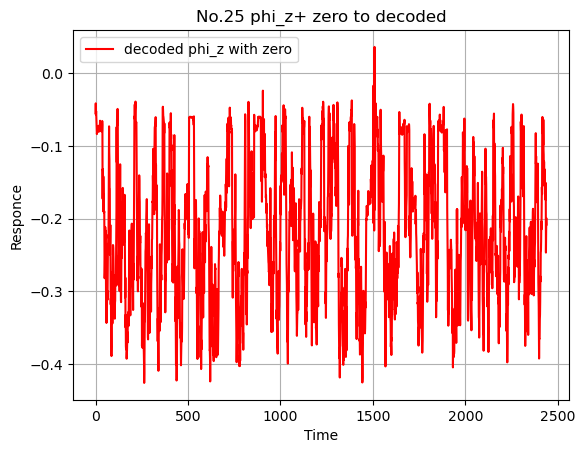

In [67]:
plt.figure()
plt.title("No.{} phi_z+ zero to decoded".format(id))
plt.plot(phi_z_zero_decoded, linestyle="-", color="red", label="decoded phi_z with zero")
#plt.plot(phi_z_noise_decoded, linestyle="-", color="blue", label="decoded phi_z with noise")
#plt.plot(np.squeeze(data_Qex[id, :]), linestyle="-", color="green",label = "x")
plt.legend()
plt.grid()
plt.ylabel('Responce')
plt.xlabel('Time')
plt.savefig(f"./result/flame_2450/decoded_No{id}_h_zero_pred24001.png")
plt.show

ValueError: x and y can be no greater than 2D, but have shapes (47800,) and (47800, 10, 1)

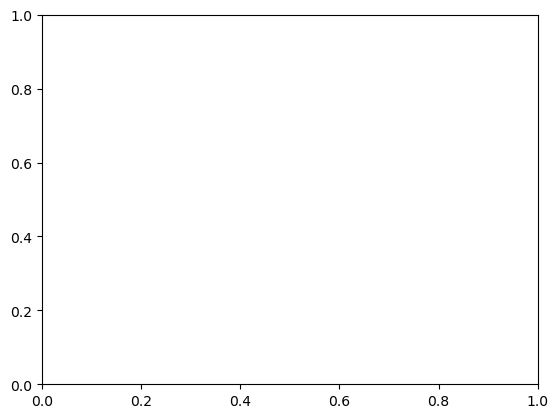

In [68]:
plt.plot(train_x)